<h2>kaggle competetions</h2>
<h3>Personalized Medicine: Redefining Cancer Treatment</h3>
https://www.kaggle.com/c/msk-redefining-cancer-treatment/

<h3>Problem statement</h3>
<ul>
<li>In this competition you will develop algorithms to classify genetic mutations based on clinical evidence (text).</li>

<li>There are nine different classes a genetic mutation can be classified on.</li>

<li>This is not a trivial task since interpreting clinical evidence is very challenging even for human specialists. Therefore, modeling the clinical evidence (text) will be critical for the success of your approach.</li>
</ul>

<h3>Requirements and objective</h3>

<ul>
<li>Interpretablity is important</li>
<li>Errors can be very costly</li>
<li>probability  of data belonging to each class</li>
</ul>


In [121]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.simplefilter('ignore')
from collections import Counter, defaultdict
from sklearn.preprocessing import normalize
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_training_variants = pd.read_csv('training_variants')

In [3]:
print("Shape of datapoints",df_training_variants.shape)

Shape of datapoints (3321, 4)


In [4]:
print("columns in data",df_training_variants.columns)

columns in data Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')


In [5]:
df_training_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [6]:
#Reading training text
df_training_text = pd.read_csv('training_text',sep='\|\|',engine='python',header=None)

In [7]:
print("Shape of text datapoints",df_training_text.shape)

Shape of text datapoints (3322, 1)


In [8]:
print("columns in text datapoints",df_training_text.columns)

columns in text datapoints Int64Index([0], dtype='int64')


In [9]:
df_training_text.head()

,0
"ID,Text",None
0,Cyclin-dependent kinases (CDKs) regulate a var...
1,Abstract Background Non-small cell lung canc...
2,Abstract Background Non-small cell lung canc...
3,Recent evidence has demonstrated that acquired...


In [10]:
#As column name is not propely assigned we will assign that
df_training_text = df_training_text.iloc[1:]

In [11]:
df_training_text.head()

,0
0,Cyclin-dependent kinases (CDKs) regulate a var...
1,Abstract Background Non-small cell lung canc...
2,Abstract Background Non-small cell lung canc...
3,Recent evidence has demonstrated that acquired...
4,Oncogenic mutations in the monomeric Casitas B...


In [12]:
df_training_text.columns = ['Text']
df_training_text.reset_index(inplace=True)

In [13]:
df_training_text.head()

,index,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [14]:
df_training_text = df_training_text.iloc[1:]

In [15]:
df_training_text.head()

,index,Text
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
5,5,Oncogenic mutations in the monomeric Casitas B...


In [16]:
df_training_text.columns = ['ID','Text']
df_training_text.head()

,ID,Text
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
5,5,Oncogenic mutations in the monomeric Casitas B...


In [17]:
df_training_variants['ID'] = df_training_variants['ID'].astype(int)
df_training_text['ID'] = df_training_text['ID'].astype(int)
final_training_data = pd.merge(df_training_variants,df_training_text,on='ID',how='left')

In [18]:
final_training_data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,NaN
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [19]:
final_training_data.dropna()

,ID,Gene,Variation,Class,Text
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...
5,5,CBL,V391I,4,Oncogenic mutations in the monomeric Casitas B...
6,6,CBL,V430M,5,Oncogenic mutations in the monomeric Casitas B...
7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...
8,8,CBL,Y371H,4,Abstract Juvenile myelomonocytic leukemia (JM...
9,9,CBL,C384R,4,Abstract Juvenile myelomonocytic leukemia (JM...
10,10,CBL,P395A,4,Oncogenic mutations in the monomeric Casitas B...


In [20]:
final_training_data.shape


(3321, 5)

In [21]:
STOPWORDS =set(stopwords.words('english')) 
def preprocessing_text(row_text,row_index,column_name):
    
    if type(row_text) is str:
        string = ''
        #replacing special chracters with space
        row_text  = re.sub('[^a-zA-Z0-9\n]', ' ', row_text)
        #converting double or more space in to single space
        row_text = re.sub('\s+', ' ', row_text)
        #converting text in to lower 
        row_text = row_text.lower()
        
        for word in row_text.split():
            if  word not in STOPWORDS:
                string += word + " "
        
        
        
        final_training_data[column_name][row_index] = string
            
        

In [22]:
for index,row in final_training_data.iterrows():
    preprocessing_text(row['Text'],row['ID'],'Text')

In [23]:
final_training_data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,NaN
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [24]:

#replacing any space with underscore
final_training_data["Gene"] = final_training_data["Gene"].str.replace("\s+", "_")
final_training_data["Variation"] = final_training_data["Variation"].str.replace("\s+", "_")

In [25]:
final_training_data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating_Mutations,1,NaN
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [26]:
y_true = final_training_data['Class'].values

In [27]:
x_train, x_test, y_train, y_test = train_test_split(final_training_data, y_true, stratify=y_true, test_size=0.2)

In [28]:
print("shape of x_train:",x_train.shape)
print("shape of x_test:",x_test.shape)
print("shape of y_train:",y_train.shape)
print("shape of y_test:",y_test.shape)

shape of x_train: (2656, 5)
shape of x_test: (665, 5)
shape of y_train: (2656,)
shape of y_test: (665,)


In [29]:
#splitting further for crossvalidation
x_train, cv_train, y_train, y_cv = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2)

In [30]:
print("shape of x_train:",x_train.shape)
print("shape of cv_train:",cv_train.shape)
print("shape of y_train:",y_train.shape)
print("shape of y_cv:",y_cv.shape)

shape of x_train: (2124, 5)
shape of cv_train: (532, 5)
shape of y_train: (2124,)
shape of y_cv: (532,)


In [31]:
train_data_distribution = x_train["Class"].value_counts().sort_index()
test_data_distribution = x_test["Class"].value_counts().sort_index()
cv_data_distribution = cv_train["Class"].value_counts().sort_index()

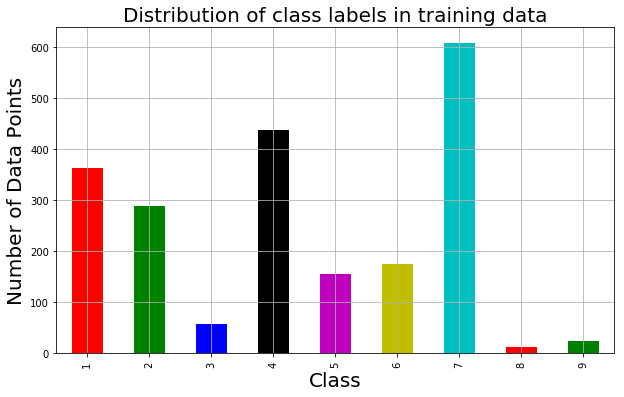

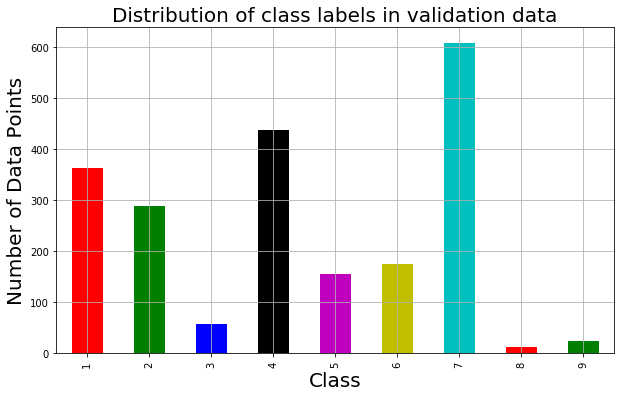

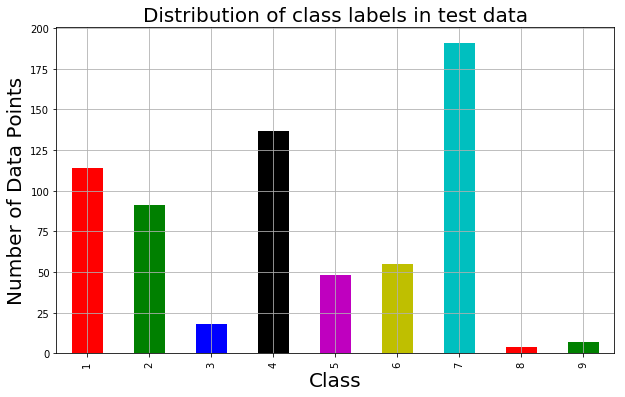

In [32]:


plt.figure(figsize = (10, 6))
train_data_distribution.plot(kind = "bar",color="rgbkmyc")
plt.grid()
plt.title("Distribution of class labels in training data", fontsize = 20)
plt.xlabel("Class", fontsize = 20)
plt.ylabel("Number of Data Points", fontsize = 20)
plt.show()



plt.figure(figsize = (10, 6))
train_data_distribution.plot(kind = "bar",color="rgbkmyc")
plt.grid()
plt.title("Distribution of class labels in validation data", fontsize = 20)
plt.xlabel("Class", fontsize = 20)
plt.ylabel("Number of Data Points", fontsize = 20)
plt.show()



plt.figure(figsize = (10, 6))
test_data_distribution.plot(kind = "bar",color="rgbkmyc")
plt.grid()
plt.title("Distribution of class labels in test data", fontsize = 20)
plt.xlabel("Class", fontsize = 20)
plt.ylabel("Number of Data Points", fontsize = 20)
plt.show()


In [33]:
def print_confusionMatrix(Y_TestLabels, PredictedLabels):
    confusionMatx = confusion_matrix(Y_TestLabels, PredictedLabels)
    
    precision = confusionMatx/confusionMatx.sum(axis = 0)
    
    recall = (confusionMatx.T/confusionMatx.sum(axis = 1)).T
    
    # confusionMatx = [[1, 2],
    #                  [3, 4]]
    # confusionMatx.T = [[1, 3],
    #                   [2, 4]]
    # confusionMatx.sum(axis = 1)  axis=0 corresponds to columns and axis=1 corresponds to rows in two diamensional array
    # confusionMatx.sum(axix =1) = [[3, 7]]
    # (confusionMatx.T)/(confusionMatx.sum(axis=1)) = [[1/3, 3/7]
    #                                                  [2/3, 4/7]]

    # (confusionMatx.T)/(confusionMatx.sum(axis=1)).T = [[1/3, 2/3]
    #                                                    [3/7, 4/7]]
    # sum of row elements = 1
    
    labels = [i for i in range(1, 10)]
    
    plt.figure(figsize=(20,7))
    sns.heatmap(confusionMatx, cmap = "YlGnBu", annot = True, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.show()
    
    print("-"*125)
    
    plt.figure(figsize=(20,7))
    sns.heatmap(precision, cmap = "YlGnBu", annot = True, fmt = ".4f", xticklabels=labels, yticklabels=labels)
    plt.title("Precision Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.show()
    
    print("-"*125)
    
    plt.figure(figsize=(20,7))
    sns.heatmap(recall, cmap = "YlGnBu", annot = True, fmt = ".3f", xticklabels=labels, yticklabels=labels)
    plt.title("Recall Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.show()


(532,)
(532, 9)
Log loss on Cross Validation Data using Random Model 2.51474450742
Log loss on Test Data using Random Model 2.5041653503


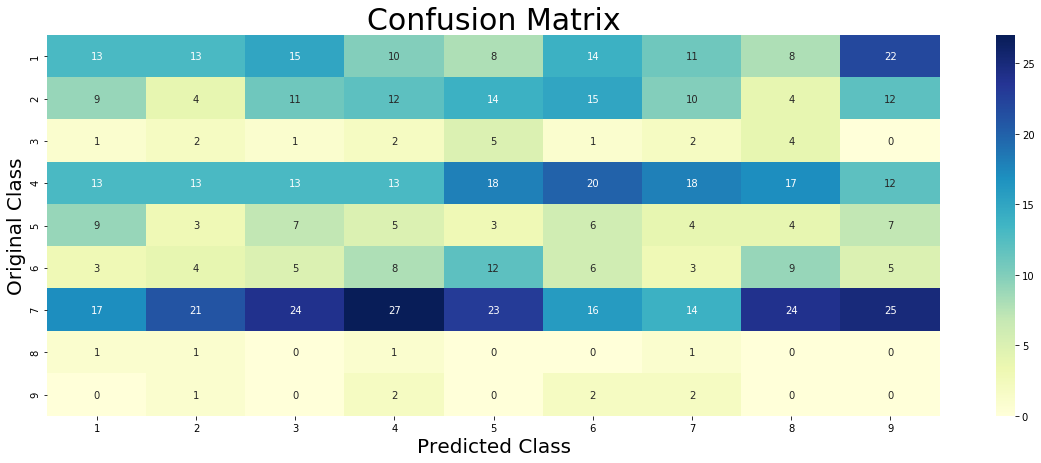

-----------------------------------------------------------------------------------------------------------------------------


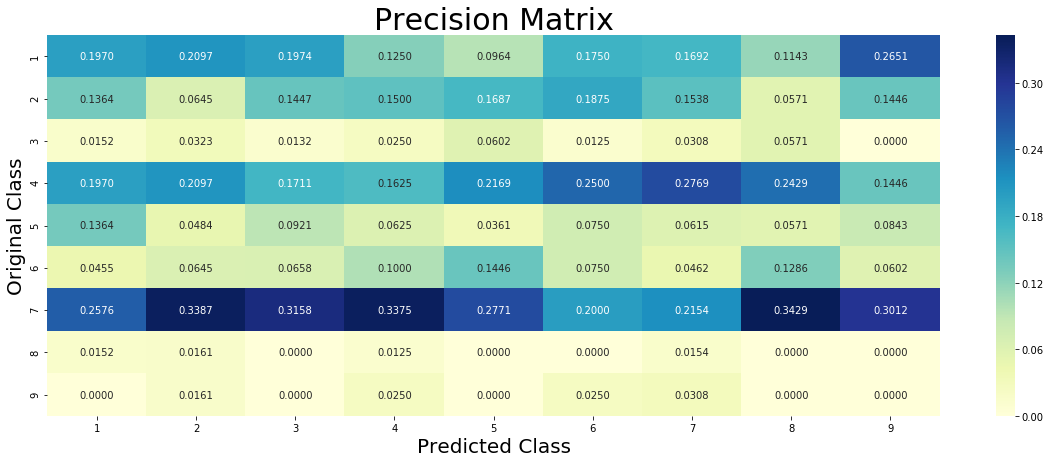

-----------------------------------------------------------------------------------------------------------------------------


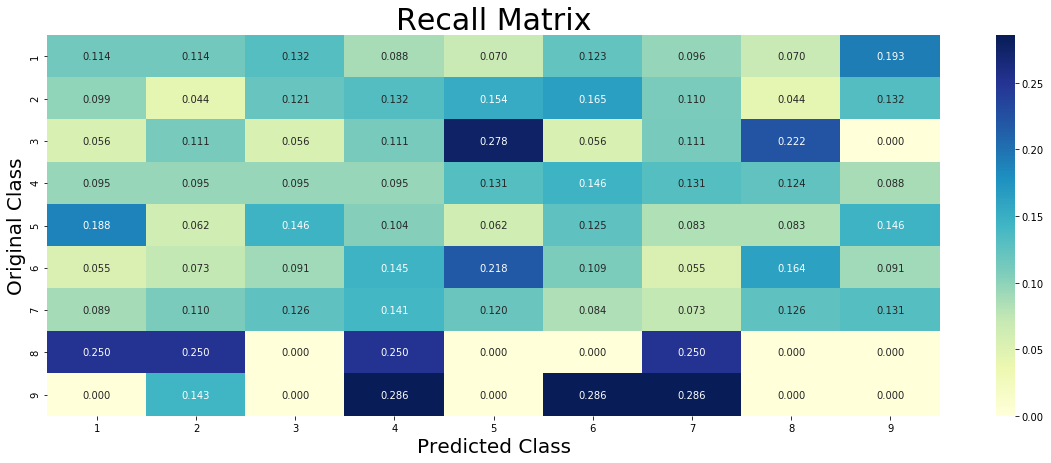

In [34]:
testDataLength = x_test.shape[0]
CVDataLength = cv_train.shape[0]

CV_predicted_probs = np.zeros((CVDataLength,9))
#print(CV_predicted_probs)
for i in range(CVDataLength):
    rand_probs_CV = np.random.rand(1,9)  #it will return an array of random numbers between 1 and 0 of size 1*9
    #print(rand_probs_CV)
    CV_predicted_probs[i] = (rand_probs_CV/sum(sum(rand_probs_CV)))[0]  #it will generate random probabilities of each point in CV data such that theor sum = 1
print(y_cv.shape) 
print(CV_predicted_probs.shape)
print("Log loss on Cross Validation Data using Random Model "+str(log_loss(y_cv,CV_predicted_probs)))


test_predicted_probs = np.zeros((testDataLength,9))
for i in range(testDataLength):
    rand_probs_test = np.random.rand(1,9)  #it will return an array of random numbers between 1 and 0 of size 1*9
    test_predicted_probs[i] = (rand_probs_test/sum(sum(rand_probs_test)))[0]  #it will generate random probabilities of each point in CV data such that theor sum = 1
print("Log loss on Test Data using Random Model "+str(log_loss(y_test, test_predicted_probs)))

pred_test_labels = np.argmax(test_predicted_probs, axis = 1)  #here, axis 1 means row wise
print_confusionMatrix(y_test, pred_test_labels+1)  #here pred_test_labels+1 plus 1 because argmax counts from 0 but our class labels are from 1 to 9

<h2>Univariate Analysis on Gene Feature</h2>

In [35]:
unique_genes = x_train["Gene"].value_counts()
print("Number of Unique genes = "+str(unique_genes.shape[0]))
print(unique_genes.head(10))

Number of Unique genes = 228
BRCA1     171
TP53      107
PTEN       88
EGFR       86
BRCA2      73
KIT        62
BRAF       57
ALK        43
ERBB2      42
PIK3CA     41
Name: Gene, dtype: int64


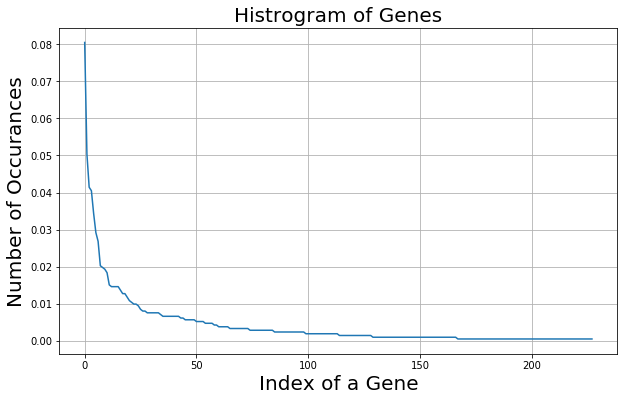

In [36]:

s = sum(unique_genes.values)
h = unique_genes.values/s
plt.figure(figsize = (10, 6))
plt.plot(h)
plt.title("Histrogram of Genes", fontsize = 20)
plt.xlabel('Index of a Gene', fontsize = 20)
plt.ylabel('Number of Occurances', fontsize = 20)
plt.grid()
plt.show()


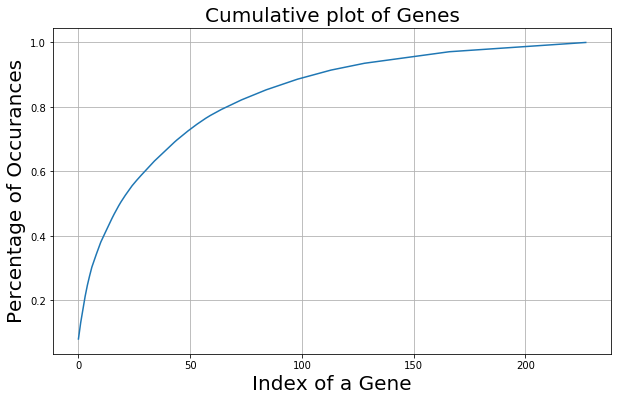

In [37]:
h = unique_genes.values/s
plt.figure(figsize = (10, 6))
plt.plot(np.cumsum(h))
plt.title("Cumulative plot of Genes", fontsize = 20)
plt.xlabel('Index of a Gene', fontsize = 20)
plt.ylabel('Percentage of Occurances', fontsize = 20)
plt.grid()
plt.show()

In [38]:
def response_coded_featureDict(alpha, feature, df):
    
    value_count = x_train[feature].value_counts()
    rc_values = dict()
    
    for i, denominator in value_count.items():
        vec = []
        for k in range(1, 10):
            cls_cnt = x_train.loc[(x_train["Class"]==k) & (x_train[feature]==i)]
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+(90*alpha))
# here, adding 10*alpha in numerator and 90*alpha in denominator is nothing but laplace smoothing which we did in Naive Bayes 
            vec.append((cls_cnt.shape[0] + 10*alpha)/denominator + (90*alpha))    
        rc_values[i] = vec
    return rc_values


def response_coded_values(alpha, feature, df):
    get_rc_values = response_coded_featureDict(alpha, feature, df)
    get_value_count = x_train[feature].value_counts()
    get_feat_values = []
    for index, row in df.iterrows():
        if row[feature] in dict(get_value_count).keys():
            get_feat_values.append(get_rc_values[row[feature]])
        else:
            get_feat_values.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return get_feat_values

In [39]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(response_coded_values(alpha, "Gene", x_train))
# test gene feature
test_gene_feature_responseCoding = np.array(response_coded_values(alpha, "Gene", x_test))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(response_coded_values(alpha, "Gene", cv_train))

In [40]:
# we convert each row values such that they sum to 1  
train_gene_feature_responseCoding = (train_gene_feature_responseCoding.T/train_gene_feature_responseCoding.sum(axis=1)).T
test_gene_feature_responseCoding = (test_gene_feature_responseCoding.T/test_gene_feature_responseCoding.sum(axis=1)).T
cv_gene_feature_responseCoding = (cv_gene_feature_responseCoding.T/cv_gene_feature_responseCoding.sum(axis=1)).T

In [41]:
print("Size of response encoded features in train data = "+str(train_gene_feature_responseCoding.shape))
print("Size of response encoded features in test data = "+str(test_gene_feature_responseCoding.shape))
print("Size of response encoded features in CV data = "+str(cv_gene_feature_responseCoding.shape))

Size of response encoded features in train data = (2124, 9)
Size of response encoded features in test data = (665, 9)
Size of response encoded features in CV data = (532, 9)


In [42]:
#for one hot encoding
geneVectorizer = CountVectorizer()
train_gene_feature_onehotCoding = geneVectorizer.fit_transform(x_train['Gene'])
test_gene_feature_onehotCoding = geneVectorizer.transform(x_test['Gene'])
cv_gene_feature_onehotCoding = geneVectorizer.transform(cv_train['Gene'])

For alpha value of 1e-05 CV log loss = 1.37564394864
For alpha value of 0.0001 CV log loss = 1.22334932492
For alpha value of 0.001 CV log loss = 1.25075066191
For alpha value of 0.01 CV log loss = 1.35398449618
For alpha value of 0.1 CV log loss = 1.42053690778
For alpha value of 1 CV log loss = 1.45536091661


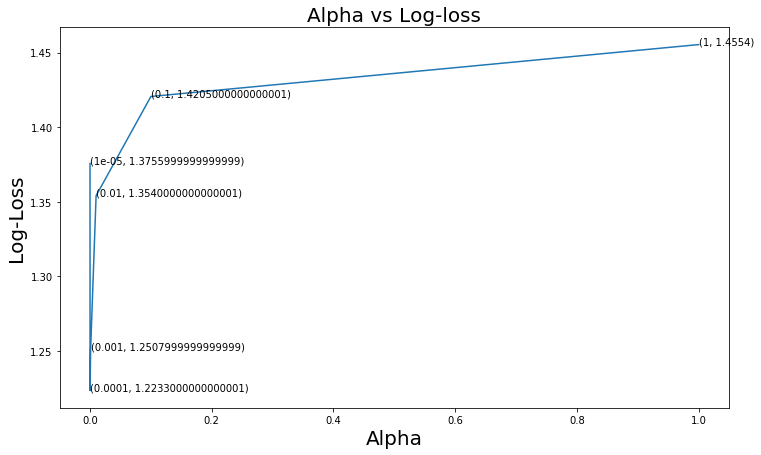

In [43]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    #this is a cross-validation
    calib_clf.fit(train_gene_feature_onehotCoding, y_train)
    predicted_y = calib_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_loss.append(log_loss(y_cv, predicted_y, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(y_cv, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

In [44]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_train = calib_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(y_train, predict_train, labels=clf.classes_))

predict_cv = calib_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(y_cv, predict_cv, labels=clf.classes_))

predict_test = calib_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(y_test, predict_test, labels=clf.classes_))


For values of best alpha =  0.0001 the train log loss =: 1.03695531328
For values of best alpha =  0.0001 the CV log loss =: 1.22334932492
For values of best alpha =  0.0001 the test log loss =: 1.19967766598


In [45]:
print("Ques: How many common gene features are there in train, cv and test data?")
gene_common_in_test = x_test[x_test["Gene"].isin(x_train["Gene"])].shape[0]
gene_common_in_cv = cv_train[cv_train["Gene"].isin(x_train["Gene"])].shape[0]
print("Ans:")
print("Percentage of common gene features in test and train data = "+str(np.round((gene_common_in_test/x_test.shape[0])*100, 2))+"%")
#it prints: Out of total features in test data, how many features are also present in train data
print("Percentage of common gene features in CV and train data = "+str(np.round((gene_common_in_cv/cv_train.shape[0])*100, 2))+"%")
#it prints: Out of total features in cv data, how many features are also present in train data

Ques: How many common gene features are there in train, cv and test data?
Ans:
Percentage of common gene features in test and train data = 95.64%
Percentage of common gene features in CV and train data = 96.99%


<h3>For variations</h3>

In [46]:
unique_variations= x_train["Variation"].value_counts()
print("Number of Unique variations = "+str(unique_variations.shape[0]))
print(unique_variations.head(10))

Number of Unique variations = 1943
Truncating_Mutations    57
Amplification           50
Deletion                39
Fusions                 21
Overexpression           4
Q61H                     3
A146V                    2
G35R                     2
E17K                     2
TMPRSS2-ETV1_Fusion      2
Name: Variation, dtype: int64


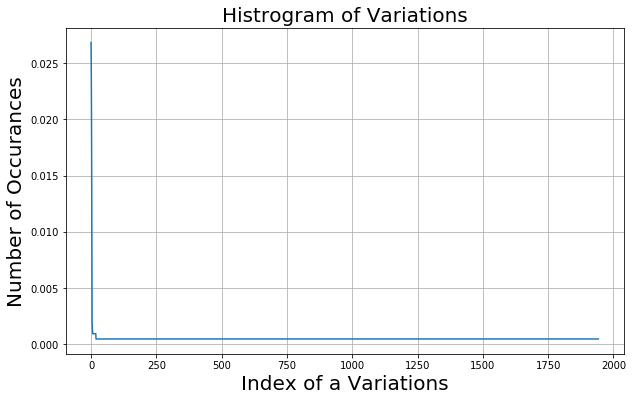

In [47]:

s = sum(unique_variations.values)
h = unique_variations.values/s
plt.figure(figsize = (10, 6))
plt.plot(h)
plt.title("Histrogram of Variations", fontsize = 20)
plt.xlabel('Index of a Variations', fontsize = 20)
plt.ylabel('Number of Occurances', fontsize = 20)
plt.grid()
plt.show()

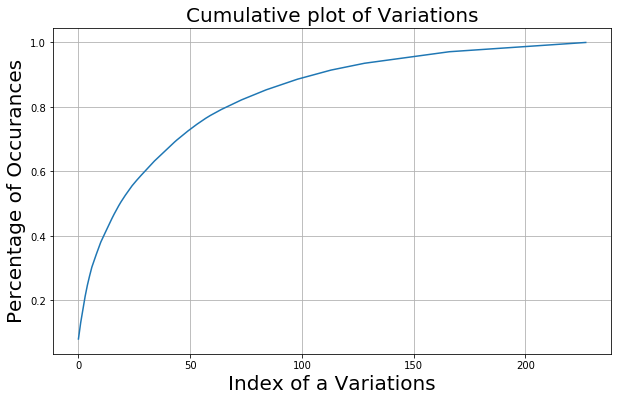

In [48]:
h = unique_genes.values/s
plt.figure(figsize = (10, 6))
plt.plot(np.cumsum(h))
plt.title("Cumulative plot of Variations", fontsize = 20)
plt.xlabel('Index of a Variations', fontsize = 20)
plt.ylabel('Percentage of Occurances', fontsize = 20)
plt.grid()
plt.show()

In [49]:
# alpha is used for laplace smoothing
alpha = 1
# train variation feature
train_variation_feature_responseCoding = np.array(response_coded_values(alpha, "Variation", x_train))
# test variation feature
test_variation_feature_responseCoding = np.array(response_coded_values(alpha, "Variation", x_test))
# cross validation variation feature
cv_variation_feature_responseCoding = np.array(response_coded_values(alpha, "Variation", cv_train))

In [50]:
#we convert each row values such that they sum to 1  
train_variation_feature_responseCoding = (train_variation_feature_responseCoding.T/train_variation_feature_responseCoding.sum(axis=1)).T
test_variation_feature_responseCoding = (test_variation_feature_responseCoding.T/test_variation_feature_responseCoding.sum(axis=1)).T
cv_variation_feature_responseCoding = (cv_variation_feature_responseCoding.T/cv_variation_feature_responseCoding.sum(axis=1)).T

In [51]:
print("Size of response encoded features in train data = "+str(train_variation_feature_responseCoding.shape))
print("Size of response encoded features in test data = "+str(test_variation_feature_responseCoding.shape))
print("Size of response encoded features in CV data = "+str(cv_variation_feature_responseCoding.shape))

Size of response encoded features in train data = (2124, 9)
Size of response encoded features in test data = (665, 9)
Size of response encoded features in CV data = (532, 9)


In [52]:
variationVectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variationVectorizer.fit_transform(x_train['Variation'])
test_variation_feature_onehotCoding = variationVectorizer.transform(x_test['Variation'])
cv_variation_feature_onehotCoding = variationVectorizer.transform(cv_train['Variation'])

In [53]:
print("Size of one-hot encoded features in train data = "+str(train_variation_feature_onehotCoding.shape))
print("Size of one-hot encoded features in test data = "+str(test_variation_feature_onehotCoding.shape))
print("Size of one-hot encoded features in CV data = "+str(cv_variation_feature_onehotCoding.shape))


Size of one-hot encoded features in train data = (2124, 1972)
Size of one-hot encoded features in test data = (665, 1972)
Size of one-hot encoded features in CV data = (532, 1972)


For alpha value of 1e-05 CV log loss = 1.71444471456
For alpha value of 0.0001 CV log loss = 1.69505499583
For alpha value of 0.001 CV log loss = 1.70204423524
For alpha value of 0.01 CV log loss = 1.71027487716
For alpha value of 0.1 CV log loss = 1.7128828933
For alpha value of 1 CV log loss = 1.71392730396


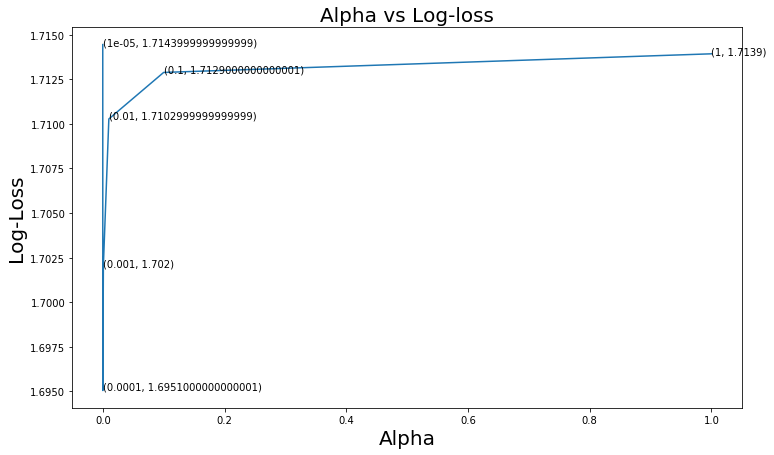

In [54]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(train_variation_feature_onehotCoding, y_train)
    predicted_y = calib_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_loss.append(log_loss(y_cv, predicted_y, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(y_cv, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

In [55]:
print("Ques: How many common variation features are there in train, cv and test data?")
variation_common_in_test = x_test[x_test["Variation"].isin(x_train["Variation"])].shape[0]
variation_common_in_cv = cv_train[cv_train["Variation"].isin(x_train["Variation"])].shape[0]
print("Ans:")
print("Percentage of common Variation features in test and train data = "+str(np.round((variation_common_in_test/x_test.shape[0])*100, 2))+"%")
#it prints: Out of total features in test data, how many features are also present in train data
print("Percentage of common Variation features in CV and train data = "+str(np.round((variation_common_in_cv/cv_train.shape[0])*100, 2))+"%")

Ques: How many common variation features are there in train, cv and test data?
Ans:
Percentage of common Variation features in test and train data = 11.88%
Percentage of common Variation features in CV and train data = 10.9%


<h2>Univariate Analysis on Text Feature</h2>

In [56]:

# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in str(row['Text']).split():
            dictionary[word] +=1
    return dictionary

In [57]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in str(row['Text']).split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(str(row['Text']).split()))
            row_index += 1
    return text_feature_responseCoding

In [60]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(x_train['Text'].values.astype('U'))
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53083


In [61]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = x_train[x_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(x_train)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [62]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(x_train)
test_text_feature_responseCoding  = get_text_responsecoding(x_test)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_train)

In [63]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [64]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(x_test['Text'].values.astype('U'))
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_train['Text'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [65]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [66]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5192, 4: 3591, 6: 2990, 5: 2955, 8: 1966, 7: 1827, 9: 1796, 10: 1608, 12: 1351, 14: 1194, 11: 971, 15: 927, 13: 898, 16: 719, 18: 689, 20: 607, 22: 599, 17: 561, 19: 532, 24: 491, 28: 482, 21: 477, 30: 365, 25: 349, 44: 341, 26: 340, 29: 337, 27: 333, 23: 324, 50: 278, 32: 277, 36: 258, 33: 251, 34: 246, 31: 244, 40: 237, 38: 226, 35: 209, 39: 208, 43: 206, 37: 203, 42: 199, 46: 182, 48: 176, 56: 175, 41: 167, 45: 163, 54: 156, 47: 152, 51: 148, 49: 145, 52: 144, 60: 135, 55: 135, 53: 134, 59: 127, 61: 125, 57: 123, 66: 122, 63: 122, 70: 110, 68: 108, 64: 108, 62: 101, 58: 101, 65: 100, 71: 98, 74: 93, 72: 90, 86: 89, 79: 89, 76: 89, 77: 83, 67: 83, 73: 81, 85: 78, 84: 77, 78: 77, 80: 75, 69: 73, 81: 71, 75: 71, 90: 69, 87: 69, 98: 66, 96: 66, 99: 65, 89: 64, 100: 63, 82: 63, 92: 62, 111: 61, 93: 61, 97: 60, 83: 59, 91: 58, 116: 57, 112: 56, 88: 56, 129: 54, 117: 54, 102: 54, 104: 53, 114: 52, 94: 52, 109: 50, 108: 50, 105: 50, 101: 50, 122: 49, 95: 49, 103: 48, 145: 47, 13

For values of alpha =  1e-05 The log loss is: 1.28922195069
For values of alpha =  0.0001 The log loss is: 1.26774178546
For values of alpha =  0.001 The log loss is: 1.11727288485
For values of alpha =  0.01 The log loss is: 1.23483488196
For values of alpha =  0.1 The log loss is: 1.46077802622
For values of alpha =  1 The log loss is: 1.64667605177


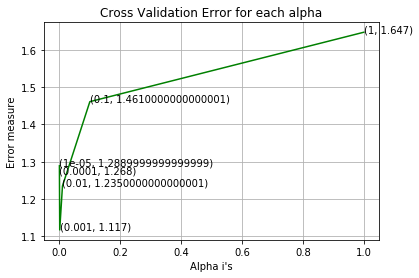

shape of train predict (2124, 9)
shape of train actual (2124,)
For values of best alpha =  0.001 The train log loss is: 0.80039596519
shape of cv predict (532, 9)
shape of cv actual (532,)
For values of best alpha =  0.001 The cross validation log loss is: 1.11727288485
shape of cv predict (665, 9)
shape of cv actual (665, 5)
For values of best alpha =  0.001 The test log loss is: 1.22752310569


In [67]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('shape of train predict',predict_y.shape)
print('shape of train actual',y_train.shape)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('shape of cv predict',predict_y.shape)
print('shape of cv actual',y_cv.shape)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('shape of cv predict',predict_y.shape)
print('shape of cv actual',x_test.shape)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [68]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['Text'].values.astype('U'))
    df_text_features = df_text_vec.get_feature_names()
    print(df_text_fea.shape)
    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [69]:
len1,len2 = get_intersec_text(x_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_train)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

(665, 29400)
96.622 % of word of test data appeared in train data
(532, 25455)
98.079 % of word of Cross Validation appeared in train data


<h1>Modelling with all feature</h1>

In [70]:
##Using machine earning models
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    print_confusionMatrix(test_y, pred_y)

In [109]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(x_train['Gene'].values.astype('U'))
    var_vec  = var_count_vec.fit(x_train['Variation'].values.astype('U'))
    text_vec = text_count_vec.fit(x_train['Text'].values.astype('U'))
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [71]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [72]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(x_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(x_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_train['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [73]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55283)
(number of data points * number of features) in test data =  (665, 55283)
(number of data points * number of features) in cross validation data = (532, 55283)


In [74]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


<h3>Naive Bayes with one hot encoding</h3>

for alpha = 1e-05
Log Loss : 1.29472404519
for alpha = 0.0001
Log Loss : 1.29251460598
for alpha = 0.001
Log Loss : 1.29630494628
for alpha = 0.1
Log Loss : 1.27561128165
for alpha = 1
Log Loss : 1.2811982249
for alpha = 10
Log Loss : 1.3696787818
for alpha = 100
Log Loss : 1.37881986431
for alpha = 1000
Log Loss : 1.30805550125


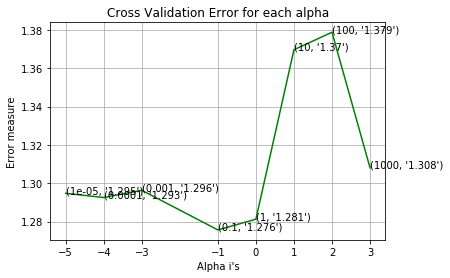

For values of best alpha =  0.1 The train log loss is: 0.902300120585
For values of best alpha =  0.1 The cross validation log loss is: 1.27561128165
For values of best alpha =  0.1 The test log loss is: 1.27752393977


In [75]:
#Naive bayes
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.27561128165
Number of missclassified point : 0.42293233082706766


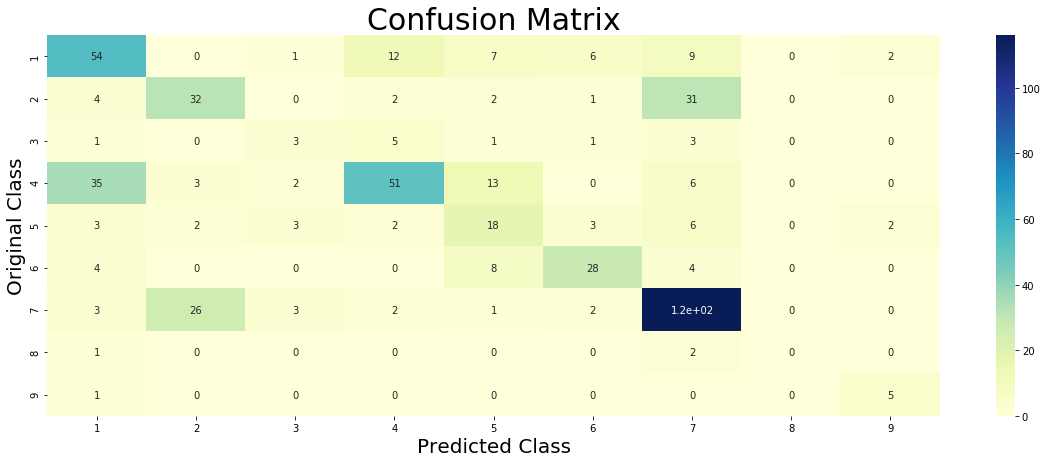

-----------------------------------------------------------------------------------------------------------------------------


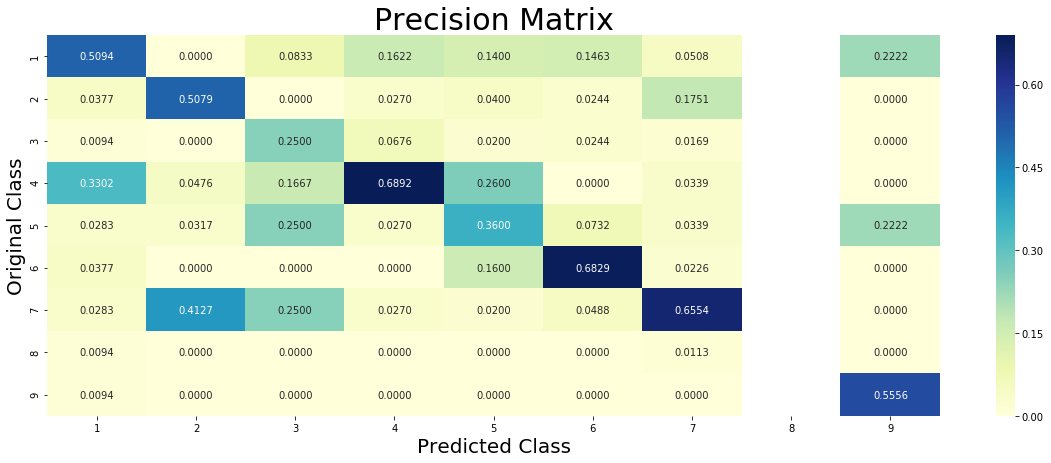

-----------------------------------------------------------------------------------------------------------------------------


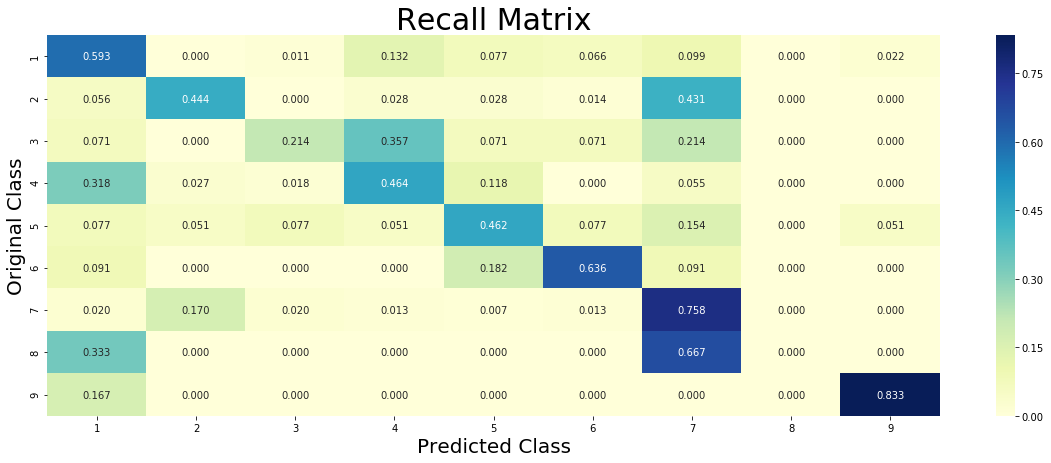

In [76]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
print_confusionMatrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [77]:
test_point_index = 20
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 1
Predicted Class Probabilities: [[ 0.5523  0.0783  0.0174  0.116   0.0421  0.041   0.1449  0.0046  0.0034]]
Actual Class : 1
--------------------------------------------------


In [78]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 7
Predicted Class Probabilities: [[ 0.078   0.0691  0.0154  0.1025  0.0372  0.0362  0.6546  0.0041  0.003 ]]
Actual Class : 4
--------------------------------------------------


<h3>KNN with response codeing</h3>

for alpha = 5
Log Loss : 1.13150636507
for alpha = 11
Log Loss : 1.14628734378
for alpha = 15
Log Loss : 1.15962495539
for alpha = 21
Log Loss : 1.16647566847
for alpha = 31
Log Loss : 1.17573890258
for alpha = 41
Log Loss : 1.17800007855
for alpha = 51
Log Loss : 1.17569660139
for alpha = 99
Log Loss : 1.17349182831


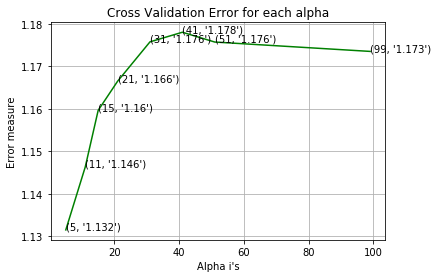

For values of best alpha =  5 The train log loss is: 0.618071355227
For values of best alpha =  5 The cross validation log loss is: 1.13150636507
For values of best alpha =  5 The test log loss is: 1.1624929434


In [79]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.13150636507
Number of mis-classified points : 0.3890977443609023


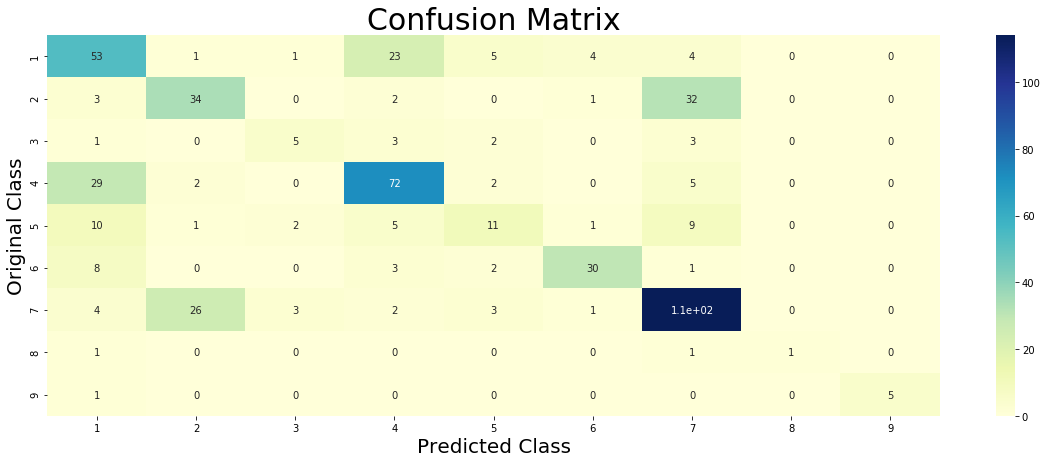

-----------------------------------------------------------------------------------------------------------------------------


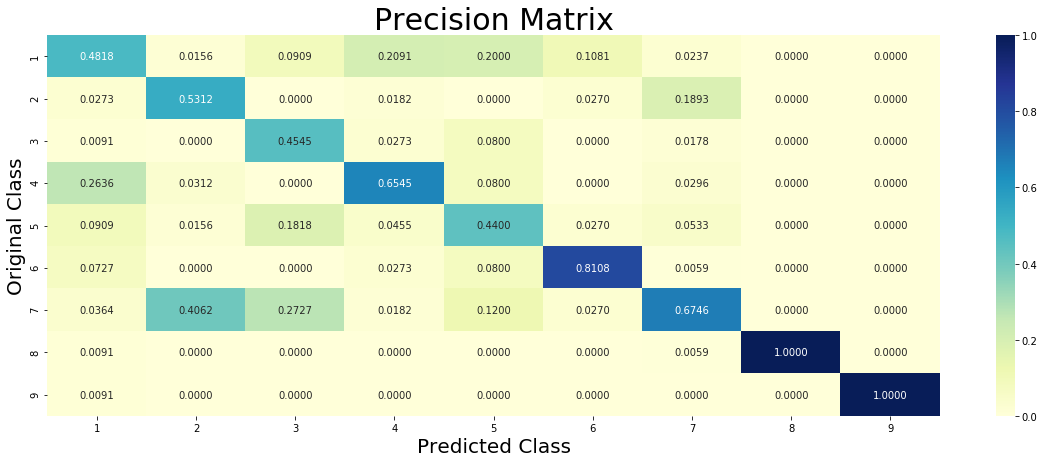

-----------------------------------------------------------------------------------------------------------------------------


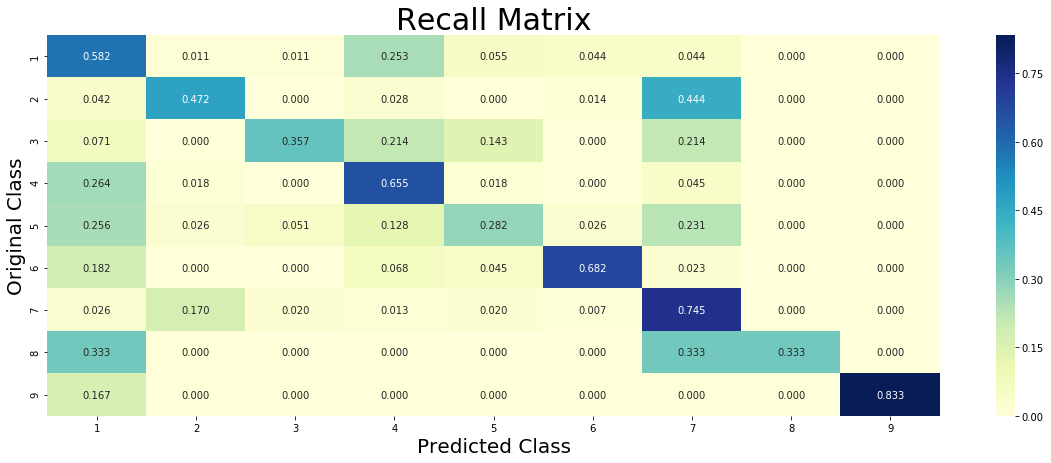

In [80]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

<h3>Logistic regresssion with one hot encoding </h3>

for alpha = 1e-06
Log Loss : 1.30753845567
for alpha = 1e-05
Log Loss : 1.31191782705
for alpha = 0.0001
Log Loss : 1.25547531712
for alpha = 0.001
Log Loss : 1.05385378983
for alpha = 0.01
Log Loss : 1.11385335579
for alpha = 0.1
Log Loss : 1.44092122418
for alpha = 1
Log Loss : 1.66991658084
for alpha = 10
Log Loss : 1.69902399763
for alpha = 100
Log Loss : 1.70211555076


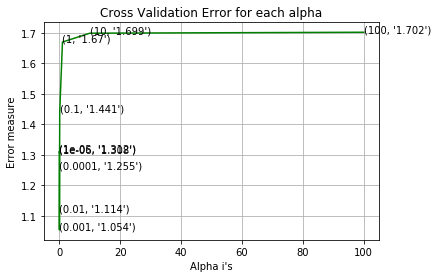

For values of best alpha =  0.001 The train log loss is: 0.6649660863
For values of best alpha =  0.001 The cross validation log loss is: 1.05385378983
For values of best alpha =  0.001 The test log loss is: 1.11926189087


In [81]:

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.05385378983
Number of mis-classified points : 0.325187969924812


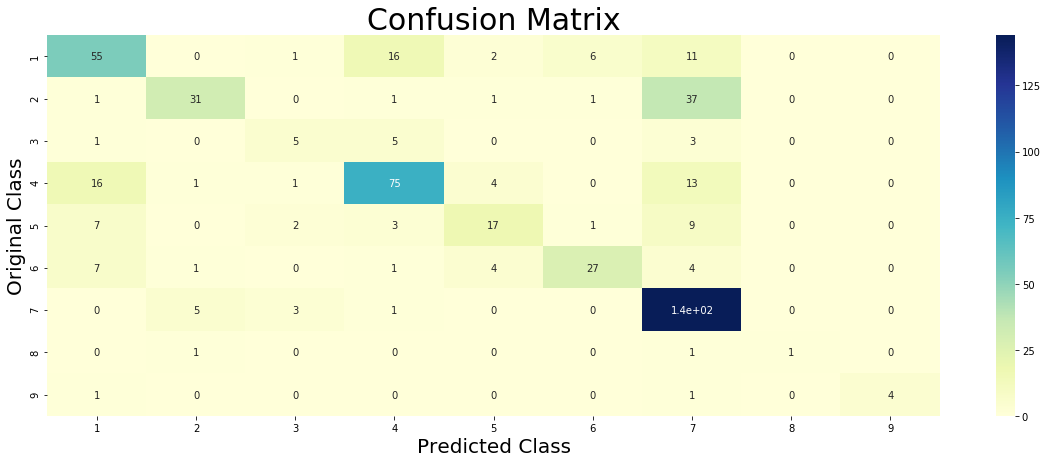

-----------------------------------------------------------------------------------------------------------------------------


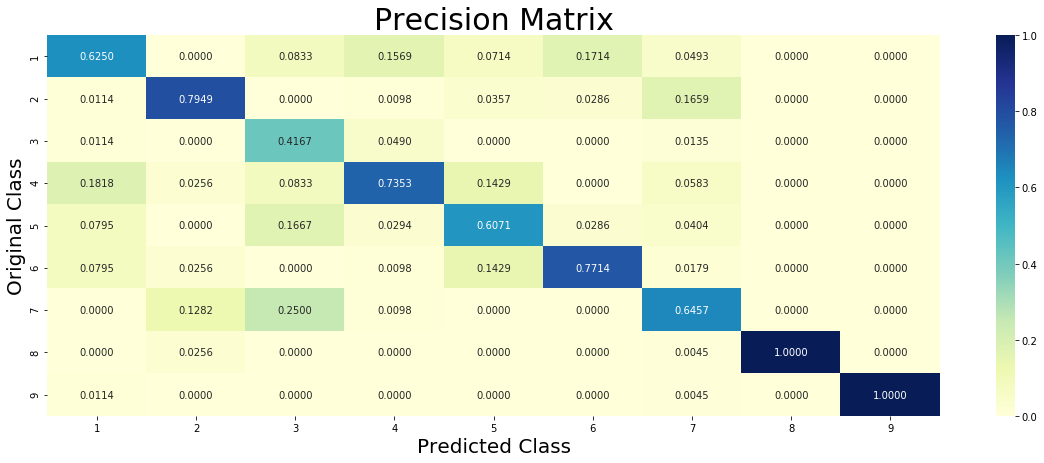

-----------------------------------------------------------------------------------------------------------------------------


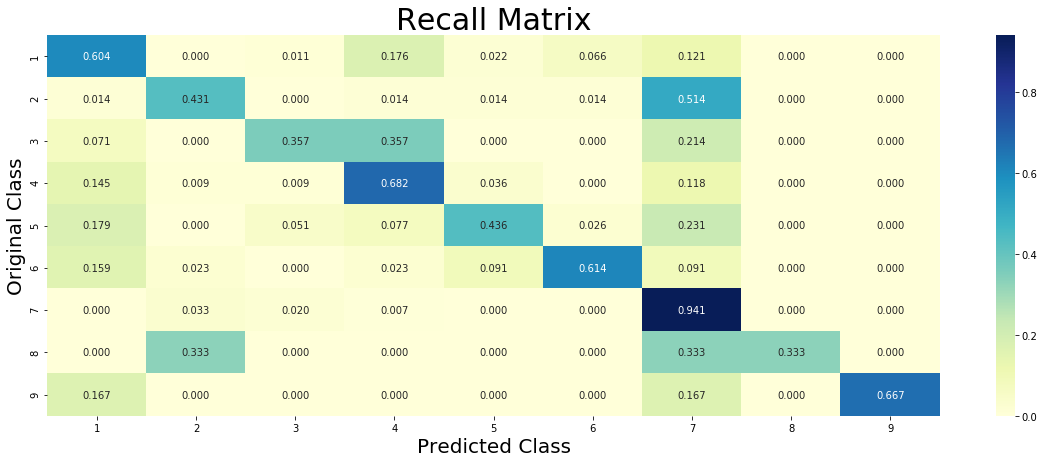

In [92]:
#------------------------------
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [111]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 120
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),3))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)

get_impfeature_names(indices[0], x_test['Text'].iloc[test_point_index],str(x_test['Gene'].iloc[test_point_index]),str(x_test['Variation'].iloc[test_point_index]), no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[ 0.01   0.025  0.004  0.17   0.009  0.757  0.016  0.004  0.005]]
Actual Class : 6
--------------------------------------------------
118 Text feature [simplex] present in test data point [True]
168 Text feature [logged] present in test data point [True]
280 Text feature [s80] present in test data point [True]
301 Text feature [floor] present in test data point [True]
451 Text feature [tagged] present in test data point [True]
473 Text feature [frame] present in test data point [True]
474 Text feature [mutants] present in test data point [True]
480 Text feature [triazole] present in test data point [True]
482 Text feature [previously] present in test data point [True]
485 Text feature [nih] present in test data point [True]
487 Text feature [constructs] present in test data point [True]
497 Text feature [2b] present in test data point [True]
498 Text feature [carrying] present in test data point [True]
Out of the top  500  features  1

<h3>Logistic regression with one hot encoding without class balancing</h3>

for alpha = 1e-06
Log Loss : 1.26438798519
for alpha = 1e-05
Log Loss : 1.2834163591
for alpha = 0.0001
Log Loss : 1.24719660658
for alpha = 0.001
Log Loss : 1.06714148879
for alpha = 0.01
Log Loss : 1.18107187555
for alpha = 0.1
Log Loss : 1.3926326004
for alpha = 1
Log Loss : 1.60057795843


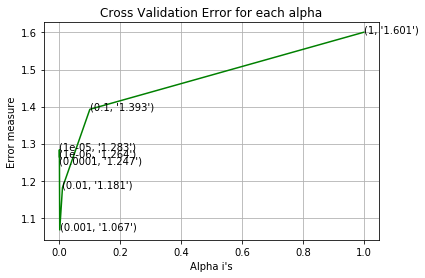

For values of best alpha =  0.001 The train log loss is: 0.66088204771
For values of best alpha =  0.001 The cross validation log loss is: 1.06714148879
For values of best alpha =  0.001 The test log loss is: 1.1554491309


In [113]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.06714148879
Number of mis-classified points : 0.3233082706766917


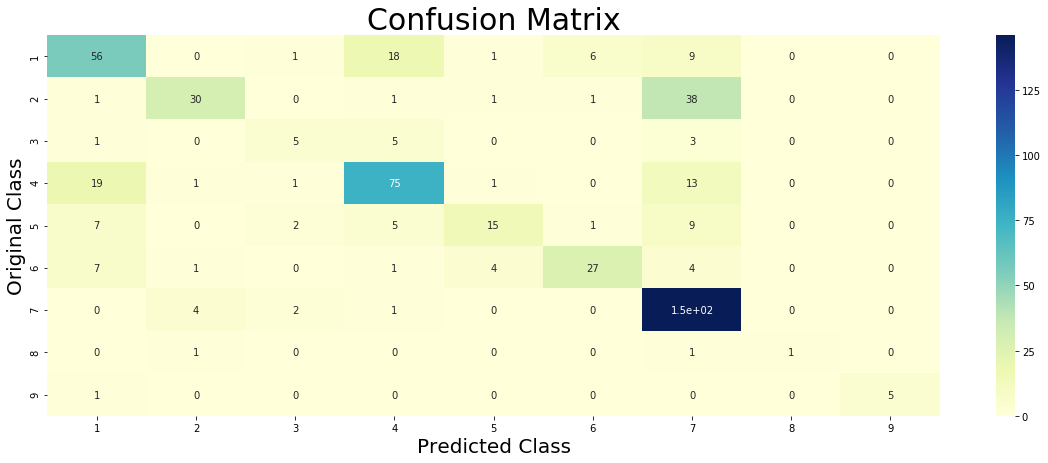

-----------------------------------------------------------------------------------------------------------------------------


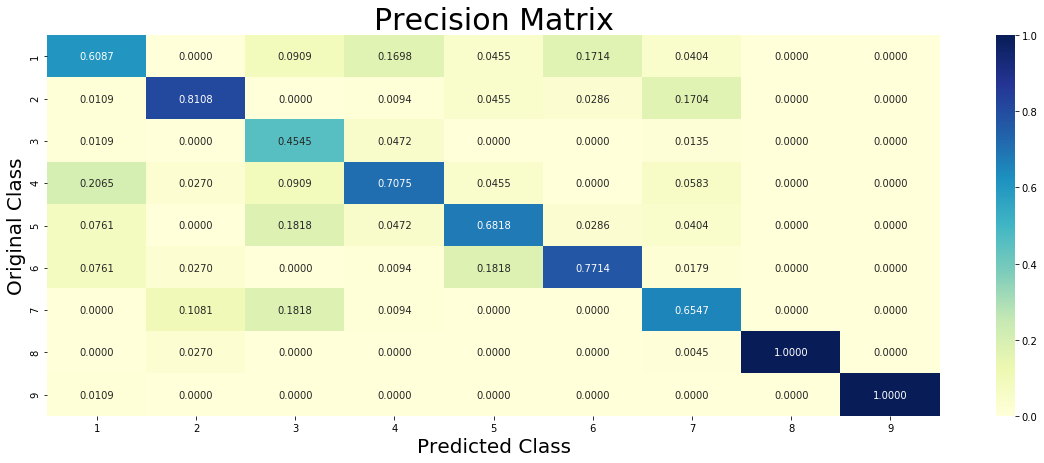

-----------------------------------------------------------------------------------------------------------------------------


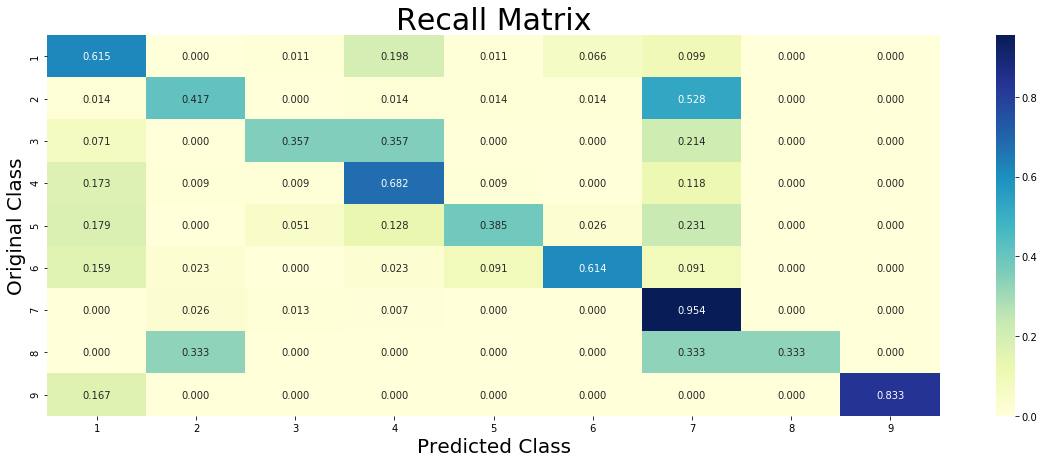

In [114]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [115]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),3))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], x_test['Text'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index],x_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[ 0.686  0.088  0.01   0.048  0.032  0.029  0.099  0.004  0.004]]
Actual Class : 1
--------------------------------------------------
321 Text feature [149] present in test data point [True]
Out of the top  500  features  1 are present in query point


<h3>Linear SVM with class balancing and one hot encoding</h3>

for C = 1e-05
Log Loss : 1.30957495111
for C = 0.0001
Log Loss : 1.2648402404
for C = 0.001
Log Loss : 1.17534914325
for C = 0.01
Log Loss : 1.09346853417
for C = 0.1
Log Loss : 1.40296126393
for C = 1
Log Loss : 1.68905526422
for C = 10
Log Loss : 1.70263636412
for C = 100
Log Loss : 1.70263635262


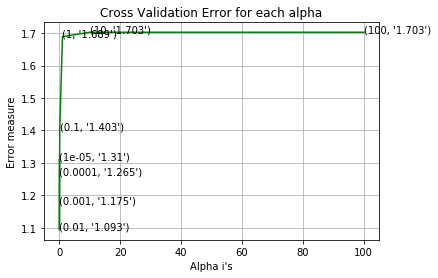

For values of best alpha =  0.01 The train log loss is: 0.788036701944
For values of best alpha =  0.01 The cross validation log loss is: 1.09346853417
For values of best alpha =  0.01 The test log loss is: 1.17022704259


In [116]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.09346853417
Number of mis-classified points : 0.34962406015037595


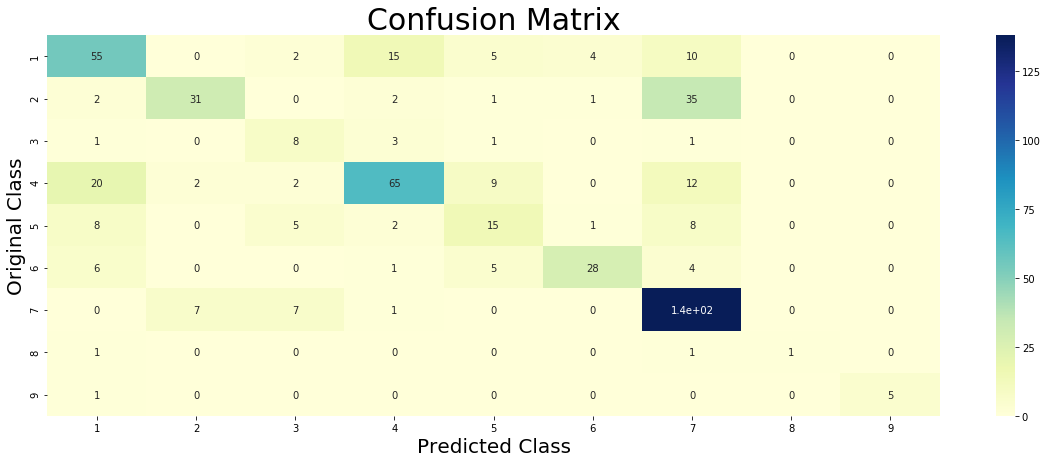

-----------------------------------------------------------------------------------------------------------------------------


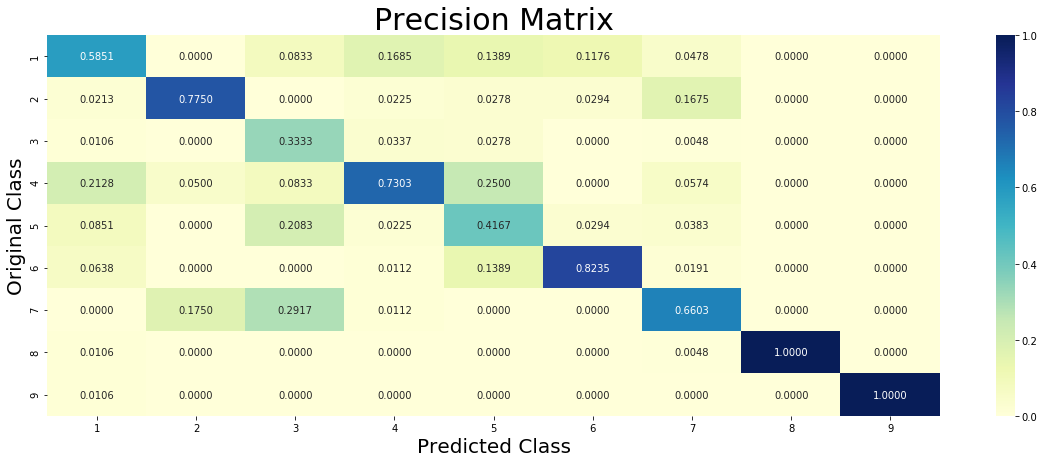

-----------------------------------------------------------------------------------------------------------------------------


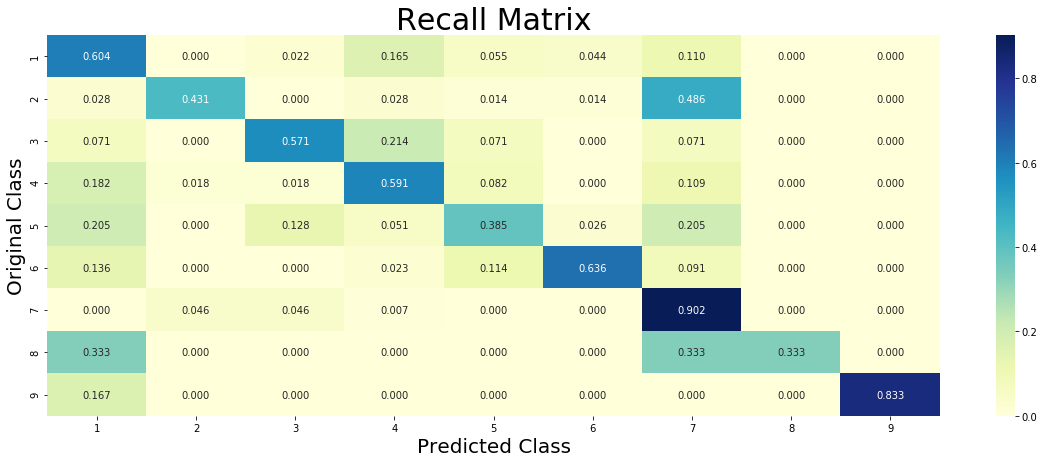

In [117]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [118]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),3))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], x_test['Text'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index],x_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[ 0.672  0.08   0.01   0.064  0.037  0.029  0.102  0.004  0.004]]
Actual Class : 1
--------------------------------------------------
287 Text feature [149] present in test data point [True]
323 Text feature [allelic] present in test data point [True]
407 Text feature [bears] present in test data point [True]
408 Text feature [a1] present in test data point [True]
422 Text feature [111] present in test data point [True]
Out of the top  500  features  5 are present in query point


<h3> Random Forest with one hot encoding</h3>

In [122]:


alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 



best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.23924029038
for n_estimators = 100 and max depth =  10
Log Loss : 1.1777793297
for n_estimators = 200 and max depth =  5
Log Loss : 1.22447417479
for n_estimators = 200 and max depth =  10
Log Loss : 1.15970279737
for n_estimators = 500 and max depth =  5
Log Loss : 1.21975148724
for n_estimators = 500 and max depth =  10
Log Loss : 1.15177854269
for n_estimators = 1000 and max depth =  5
Log Loss : 1.20830002564
for n_estimators = 1000 and max depth =  10
Log Loss : 1.14309013996
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2062130124
for n_estimators = 2000 and max depth =  10
Log Loss : 1.14374888295
For values of best estimator =  1000 The train log loss is: 0.732506599315
For values of best estimator =  1000 The cross validation log loss is: 1.14309013996
For values of best estimator =  1000 The test log loss is: 1.17627491866


Log loss : 1.14309013996
Number of mis-classified points : 0.36278195488721804


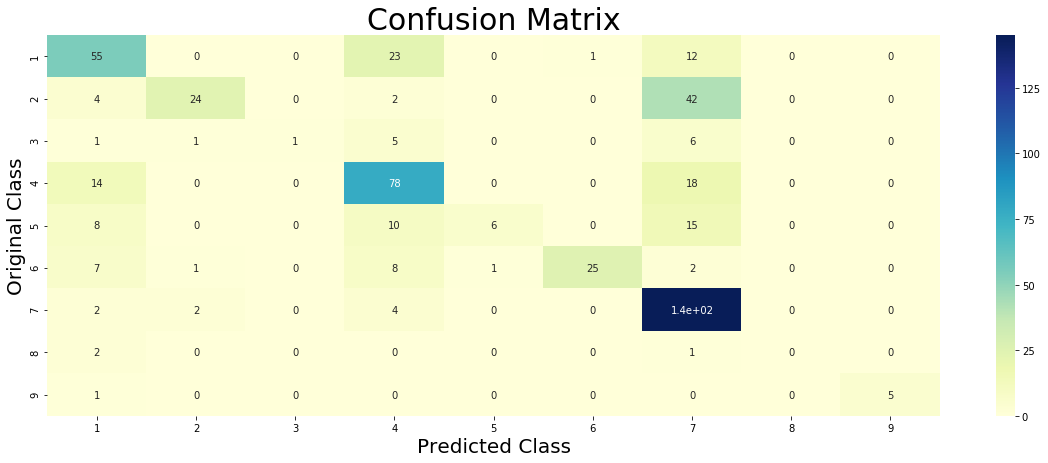

-----------------------------------------------------------------------------------------------------------------------------


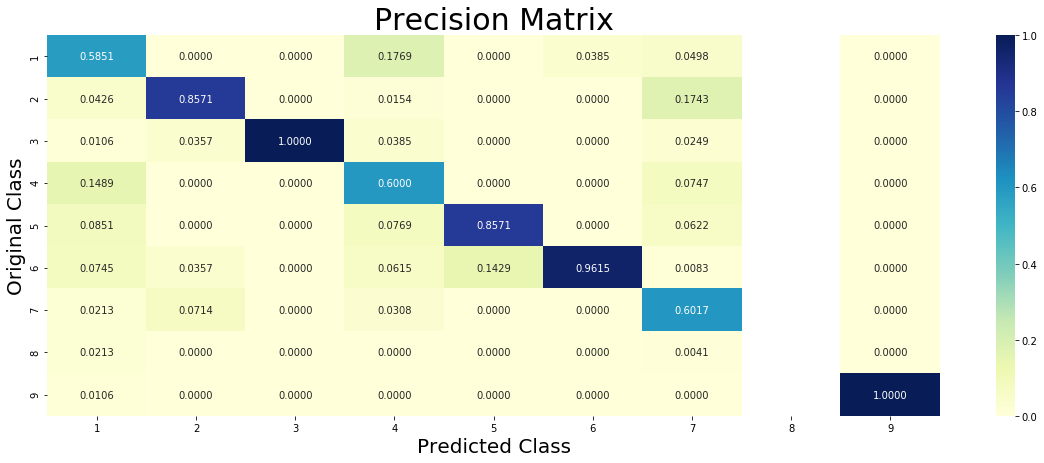

-----------------------------------------------------------------------------------------------------------------------------


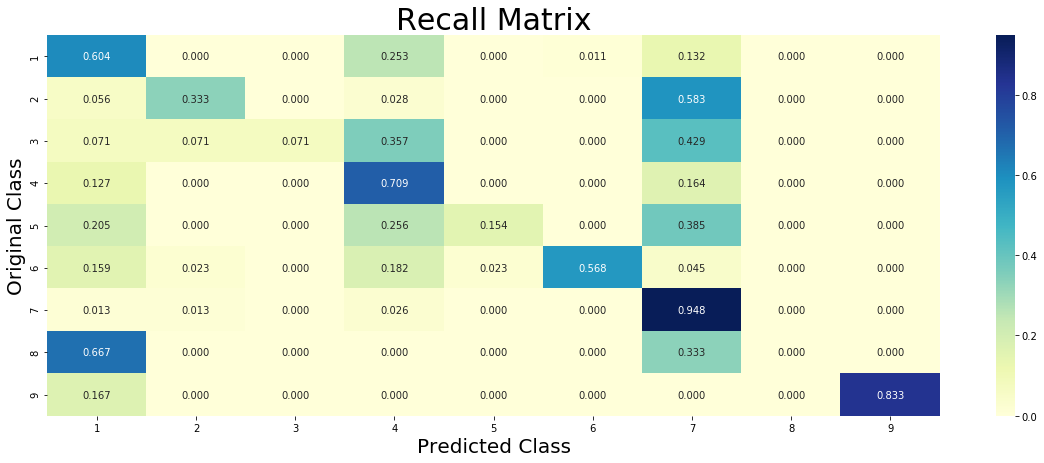

In [123]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [125]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], x_test['Text'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index],x_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[ 0.3224  0.1164  0.0246  0.2716  0.0766  0.0688  0.1043  0.0069  0.0083]]
Actual Class : 1
--------------------------------------------------
6 Text feature [activated] present in test data point [True]
14 Text feature [function] present in test data point [True]
19 Text feature [therapy] present in test data point [True]
26 Text feature [inhibition] present in test data point [True]
27 Text feature [cells] present in test data point [True]
32 Text feature [frameshift] present in test data point [True]
34 Text feature [patients] present in test data point [True]
41 Text feature [variants] present in test data point [True]
51 Text feature [cell] present in test data point [True]
58 Text feature [transformation] present in test data point [True]
62 Text feature [downstream] present in test data point [True]
64 Text feature [protein] present in test data point [True]
68 Text feature [survival] present in test data point [True]
70 Text f

In [126]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.04838683238
for n_estimators = 10 and max depth =  3
Log Loss : 1.74224815776
for n_estimators = 10 and max depth =  5
Log Loss : 1.5307026313
for n_estimators = 10 and max depth =  10
Log Loss : 1.89031879796
for n_estimators = 50 and max depth =  2
Log Loss : 1.74889756346
for n_estimators = 50 and max depth =  3
Log Loss : 1.41013205171
for n_estimators = 50 and max depth =  5
Log Loss : 1.44120082918
for n_estimators = 50 and max depth =  10
Log Loss : 1.71158778481
for n_estimators = 100 and max depth =  2
Log Loss : 1.62801452845
for n_estimators = 100 and max depth =  3
Log Loss : 1.45036927407
for n_estimators = 100 and max depth =  5
Log Loss : 1.42497084207
for n_estimators = 100 and max depth =  10
Log Loss : 1.64158485625
for n_estimators = 200 and max depth =  2
Log Loss : 1.6069620174
for n_estimators = 200 and max depth =  3
Log Loss : 1.45219283603
for n_estimators = 200 and max depth =  5
Log Loss : 1.42512468814
fo

Log loss : 1.41013205171
Number of mis-classified points : 0.5263157894736842


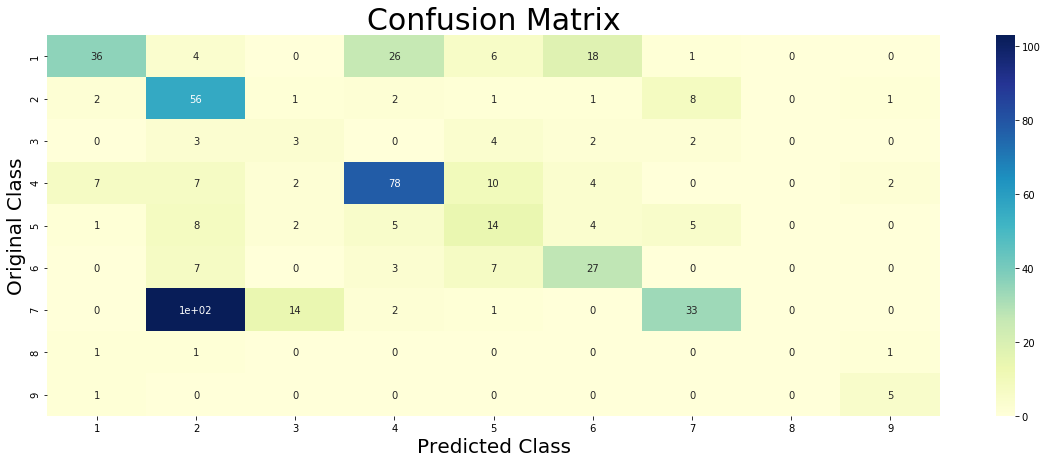

-----------------------------------------------------------------------------------------------------------------------------


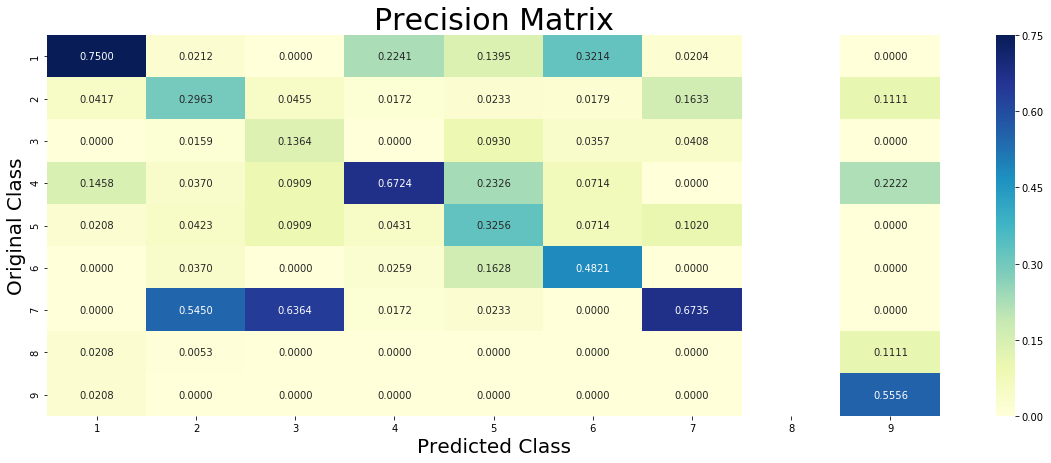

-----------------------------------------------------------------------------------------------------------------------------


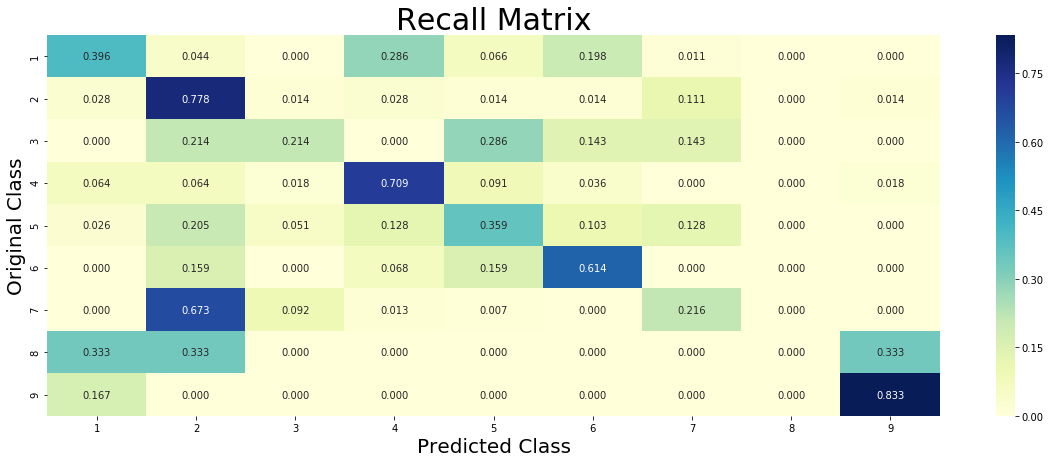

In [127]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

In [129]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),3))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 1
Predicted Class Probabilities: [[ 0.973  0.003  0.005  0.005  0.001  0.003  0.     0.004  0.005]]
Actual Class : 1
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Variation is important feature
